<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP

In [1]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

import numpy as np
import os
import random
import tensorflow as tf # 2.2.0

SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [19]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


DATA PROCESSING

In [20]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [55]:
img_width, img_height = 256, 256 
nb_train_samples = 560
nb_validation_samples = 140
epochs = 30
batch_size = 16

In [56]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [57]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [58]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

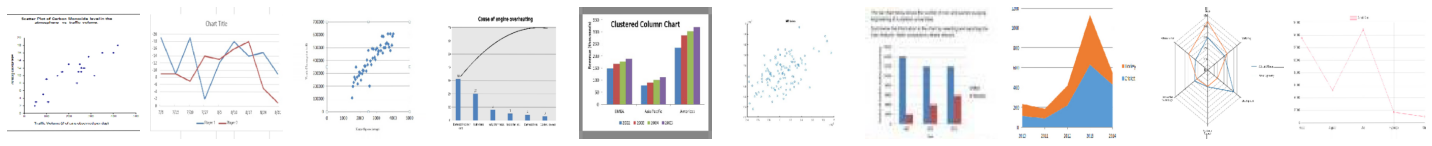

In [59]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:10])

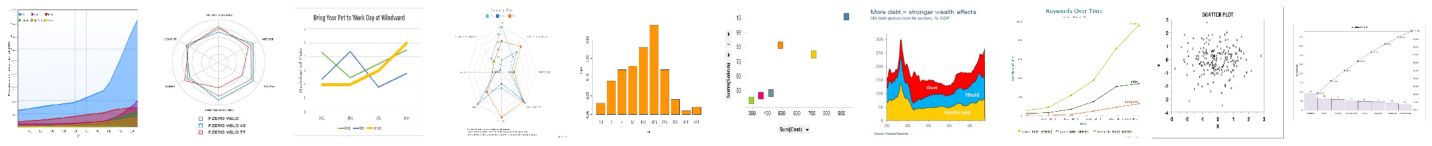

In [38]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

In [60]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


model.compile(optimizer=keras.optimizers.Adam() ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)            

In [30]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy. But this will normalize and converge at the end of model.fit
history = model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/30
35/35 [==============================] - 10s 284ms/step - loss: 5.1363 - accuracy: 0.2732 - val_loss: 1.6110 - val_accuracy: 0.3359
Epoch 2/30
35/35 [==============================] - 10s 287ms/step - loss: 1.3102 - accuracy: 0.4893 - val_loss: 1.5067 - val_accuracy: 0.5000
Epoch 3/30
35/35 [==============================] - 10s 284ms/step - loss: 1.0381 - accuracy: 0.6375 - val_loss: 1.0860 - val_accuracy: 0.6875
Epoch 4/30
35/35 [==============================] - 10s 281ms/step - loss: 0.8664 - accuracy: 0.7071 - val_loss: 0.9174 - val_accuracy: 0.7500
Epoch 5/30
35/35 [==============================] - 10s 285ms/step - loss: 0.7681 - accuracy: 0.7500 - val_loss: 1.0872 - val_accuracy: 0.6875
Epoch 6/30
35/35 [==============================] - 10s 283ms/step - loss: 0.7060 - accuracy: 0.7679 - val_loss: 0.9290 - val_accuracy: 0.7500
Epoch 7/30
35/35 [==============================] - 10s 279ms/step - loss: 0.5833 - accuracy: 0.7875 - val_loss: 1.2736 - val_accuracy: 0.6562

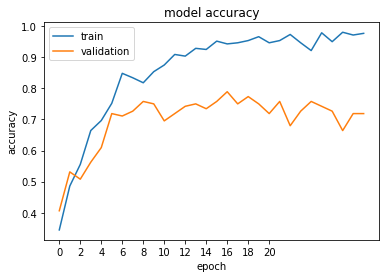

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,21, 2))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

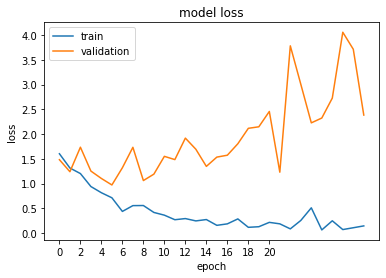

In [12]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,21, 2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
print(validation_generator.class_indices)

{'AreaChart': 0, 'BarChart': 1, 'LineChart': 2, 'ParetoChart': 3, 'PieChart': 4, 'RadarChart': 5, 'ScatterPlot': 6}


In [ ]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = nb_validation_samples // batch_size)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))